In [1]:
import numpy as np
import os
from scipy import stats
import matplotlib.pyplot as plt
from astropy.io import fits
from regions import PixCoord, CirclePixelRegion
from scipy.optimize import curve_fit
from scipy import signal

In [2]:
def Imshow(image, **kwargs):
    """
    Simple function to an image.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.colorbar()
    plt.show()

In [3]:
os.chdir("/Users/a16472/Desktop/dcf_python/vela-c/")

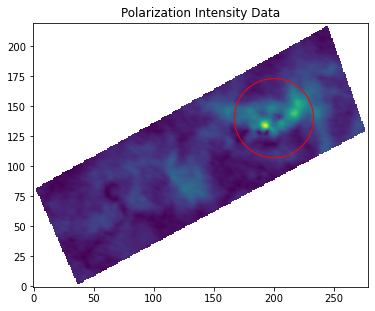

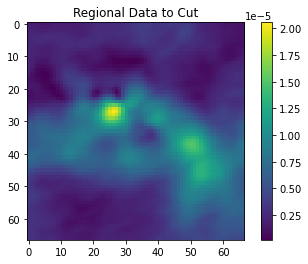

In [17]:
data = fits.open("VelaC_500_intermediate_regrid_30as_pix_polint.fits")[0].data

## Selecting Region or regions
x_cen = 200
y_cen = 140
rad = 33

# Showing where we are taking the cut.
fig, ax = plt.subplots(figsize=(6, 6))
plt.title("Polarization Intensity Data")
region = CirclePixelRegion(center=PixCoord(x=x_cen, y=y_cen), radius=rad)
plt.imshow(data, origin='lower')
region.plot(ax=ax, color='red')
plt.show()

center = PixCoord(x_cen, y_cen)
reg = CirclePixelRegion(center, rad)
mask = reg.to_mask() #this is how we mask the data!

# Cut out our data here
mask = reg.to_mask(mode='center')
dt = mask.cutout(data)
weighted_data = mask.multiply(data)

plt.figure()
plt.title("Regional Data to Cut")
plt.imshow(dt, origin='upper')
plt.colorbar()
plt.show()

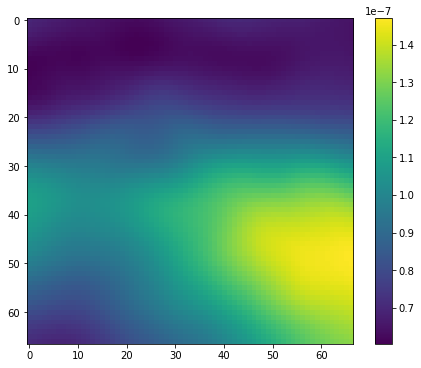

In [18]:
# convolves the map with itself to obtain the autocorrelation
map_auto = signal.convolve2d(dt, dt, boundary='symm', mode='same')
Imshow(map_auto)

In [19]:
auto_max = np.max(map_auto)
x_max, y_max = np.where(map_auto == auto_max)

pix_res = 0.5 #arcminute pixel resolution.
map_x = 0
map_y = 0
delta_r = np.zeros(dt.shape[0] * dt.shape[1])
auto = np.zeros(dt.shape[0] * dt.shape[1])
c = 0

for i in range(dt.shape[0]):
    for j in range(dt.shape[1]):
        map_x = (i - x_max) * pix_res
        map_y = (j - y_max) * pix_res
        delta_r[c] = np.sqrt(map_x**2 + map_y**2)
        auto[c] = map_auto[i, j]
        c += 1

In [20]:
print("Autocorrelation\n", auto)
print("\nDistances\n", delta_r)

Autocorrelation
 [6.96835066e-08 6.91986230e-08 6.86850262e-08 ... 1.30904504e-07
 1.31488954e-07 1.32037015e-07]

Distances
 [41.10048662 40.70012285 40.30198506 ...  8.55862138  8.51469318
  8.5       ]


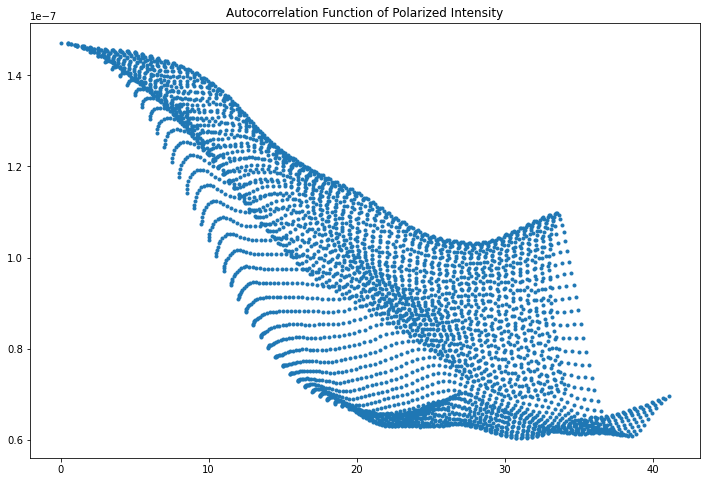

In [21]:
plt.figure(figsize=(12,8))
plt.title("Autocorrelation Function of Polarized Intensity")
plt.plot(delta_r, auto, marker='.', linestyle='None')
plt.show()

[0.10713061 0.1015435  0.09562554 ... 0.81255423 0.81928861 0.82560368]


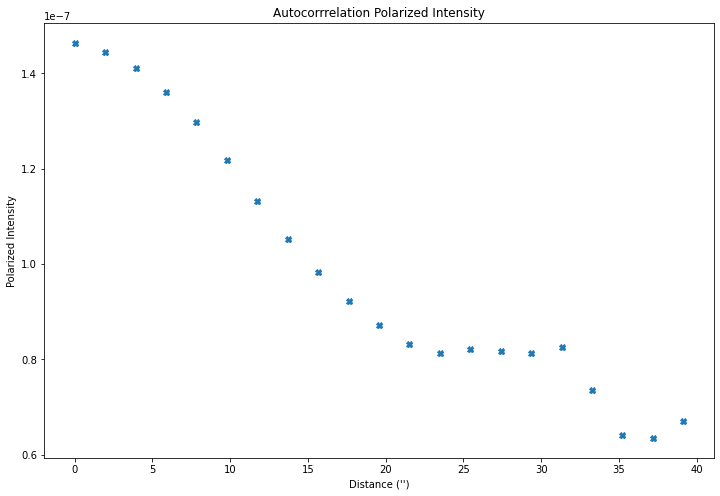

In [22]:
nlen = (3*(dt.shape[0]/2)+1)
minb = -0.5 * pix_res
maxb = (2*nlen-3) * abs(minb)

norm_auto = (auto-min(auto))/(max(auto)-min(auto))
print(norm_auto)

# Just a Binned statistics from this point?
from scipy import stats

pol_int_bins, bin_edges, _ = stats.binned_statistic(delta_r, auto, 'mean', bins=21)
norm_pol_int_bins, norm_bin_edges, _ = stats.binned_statistic(delta_r, norm_auto, 'mean', bins=21)

plt.figure(figsize=(12,8))
plt.title("Autocorrrelation Polarized Intensity")
plt.plot(bin_edges[:-1], pol_int_bins, linestyle ="none", marker="X", label="Data Points")
plt.xlabel("Distance ('')")
plt.ylabel("Polarized Intensity")
plt.show()

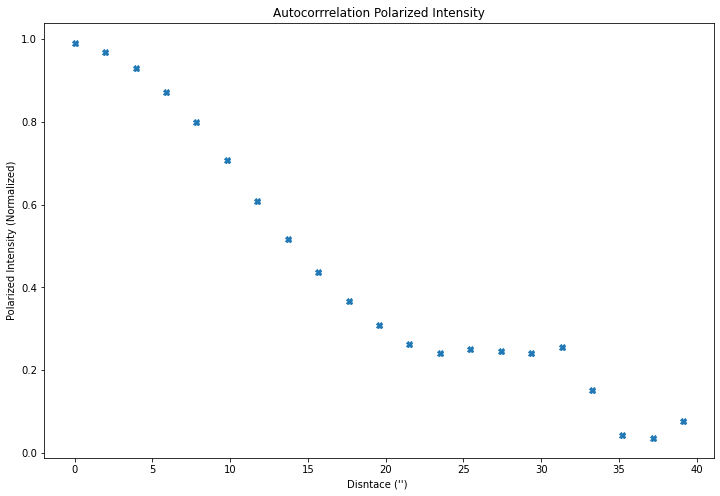

In [23]:
plt.figure(figsize=(12,8))
plt.title("Autocorrrelation Polarized Intensity")
plt.plot(norm_bin_edges[:-1], norm_pol_int_bins, linestyle ="none", marker="X", label="Data Points")
plt.xlabel("Disntace ('') ")
plt.ylabel("Polarized Intensity (Normalized)")
plt.show()

In [24]:
print(norm_bin_edges)
print(norm_pol_int_bins)


[ 0.          1.95716603  3.91433206  5.87149809  7.82866412  9.78583015
 11.74299618 13.70016221 15.65732823 17.61449426 19.57166029 21.52882632
 23.48599235 25.44315838 27.40032441 29.35749044 31.31465647 33.2718225
 35.22898853 37.18615456 39.14332059 41.10048662]
[0.99156071 0.96830302 0.93036915 0.87155945 0.79876048 0.70745251
 0.60952747 0.51733452 0.43741658 0.36683081 0.30839298 0.26252181
 0.24046119 0.24988832 0.24632183 0.24190254 0.25496856 0.15133065
 0.04332758 0.03557361 0.07730971]
